In [1]:
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2
import os
import pdb
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import random
SEED = 123
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
from train_OOP import *
from datasets import *

2024-05-25 00:41:31.834841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 00:41:32.738411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
best_checkpoint = torch.load("./fast-vol/experiments/resnet18-50bins-per-obj/1/epoch9.pth")

In [5]:
best_checkpoint.keys()

dict_keys(['model_state', 'epoch', 'iter'])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.resnet18()
num_bins = 50
model.fc = nn.Linear(512,num_bins*3)
model.load_state_dict(best_checkpoint['model_state'])
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
train_set, val_set, test_set = partitionSpinsPerObject(split_props=[0.7,0.1,0.2])

Total 7622 spin ID's partitioned into train/val/test of sizes: 5335 / 762 / 1525.
Reproducibility check -- first 10 spinIDs: ['d8079256', 'f1345e2d', 'e80052b8', '1af72aa9', 'c445cf97', '4308cf86', '461024bf', '0352677e', 'f859035d', 'a79fe5c0']
On split train: Taking 1/3 subset of spins dataset, eg. 24 of 72 imgs per object.
On split val: Taking 1/3 subset of spins dataset, eg. 24 of 72 imgs per object.
On split test: Taking 1/3 subset of spins dataset, eg. 24 of 72 imgs per object.


In [8]:
val_loader = torch.utils.data.DataLoader(
    dataset=val_set, batch_size=96,
    drop_last=False, shuffle=True,
    num_workers=8, pin_memory=True
)

In [9]:
def _preprocess_imgs(imgs):
        transform = v2.Compose([v2.ToDtype(torch.float32)])
        trans_imgs = torch.stack([transform(img) for img in imgs]) # uint8[0,255] --> float[0.,255.]
        assert torch.all(torch.isfinite(trans_imgs))
        # float[0.,255.] --> float[0.,1.] --> float[-1.,1.]
        norm_imgs = (trans_imgs/255. - 0.5) / (0.5 + 1e-6)
        assert torch.all(torch.isfinite(norm_imgs))
        return trans_imgs, norm_imgs

def _discretize_bboxes(bboxes, num_bins=50):
    trans_max = torch.tensor(5.0)
    trans_min = torch.tensor(0.0)
    trans_labels = bboxes
    trans_bins = torch.linspace(start=trans_min,
                                end=trans_max,steps=num_bins+1,
                                device=device)
    classes = torch.searchsorted(sorted_sequence=trans_bins, 
                                 input=trans_labels)
    print(f"bboxes: {bboxes[::20]}")
    classes = torch.clamp(classes, min=1, max=num_bins) - 1
    print(f"classes: {classes[::20]}")
    assert classes.shape==bboxes.shape
    return classes



In [10]:

def _verify_preprocessed_imgs(orig_imgs, trans_imgs, split, labels, predictions, iter):
    # k = 128 / 
    # Convert logits to class predictions of shape (batch,3).
    
    # Take small subset for visualization.
    predictions = torch.argmax(predictions, dim=1)[0::12]
    labels = labels[0::12]
    trans_imgs = trans_imgs[0::12]
    
    # Create matplot figure, populate with image and title as prediction+label
    ncols=4
    nrows=2
    fig,axes = plt.subplots(ncols=ncols, nrows=nrows, num=1, clear=True)
    fig.set_size_inches(2.5*ncols,2.5*nrows)
    axes = axes.flatten()
    # assert len(axes)==len(predictions)
    assert len(predictions)==len(labels)
    assert len(labels)==len(trans_imgs)
    # Loop thru and populate matplot fig
    for i,(pred,label,img,ax) in enumerate(zip(predictions,labels,trans_imgs,axes)):
        img = img.type(torch.uint8)
        img = torchvision.transforms.functional.to_pil_image(img)
        ax.imshow(img)
        prediction_str = f"{str(pred.cpu().tolist())}->{str(label.cpu().tolist())}"
        ax.set_title(label=prediction_str)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle(f"Accuracy peek on {len(axes)} imgs: (pred)->(label)")
    fig.tight_layout()
    fig.show()
    fig.savefig(f"./accuracy_peeks/val_accuracy_peek_iter{iter}.png")
    # self.writer.add_figure(tag=f"accuracy_peek ({split})",figure=fig,global_step=iter)
    fig.clear()
    plt.close(fig) 
    return

  0% 0/191 [00:00<?, ?it/s]

bboxes: tensor([[0.9398, 0.9525, 1.9304],
        [0.5080, 0.5080, 1.0414],
        [0.4115, 0.4699, 0.5715],
        [0.0127, 1.1938, 1.8034],
        [0.1250, 0.3175, 0.4600]], device='cuda:0')
classes: tensor([[ 9,  9, 19],
        [ 5,  5, 10],
        [ 4,  4,  5],
        [ 0, 11, 18],
        [ 1,  3,  4]], device='cuda:0')


  0% 0/191 [00:06<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './accuracy_peeks/val_accuracy_peek_iter0.png'

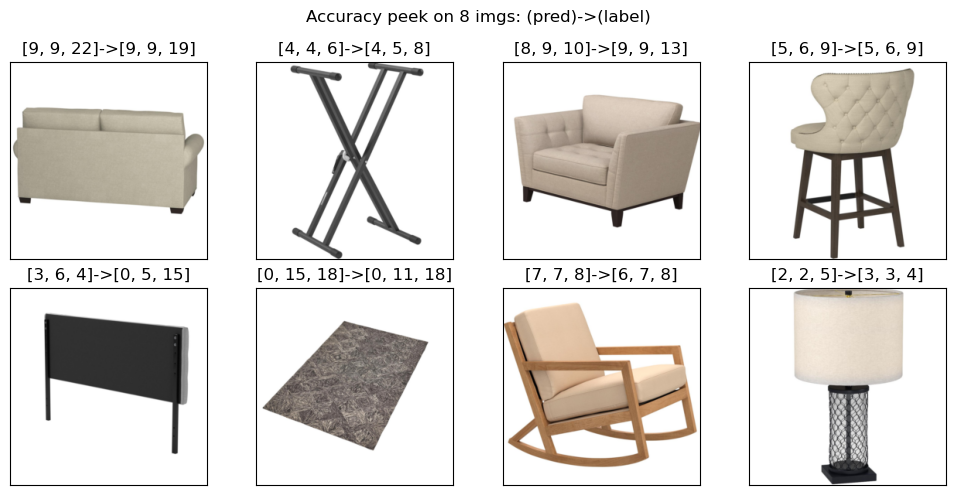

In [11]:

for i,(imgs,bboxes) in enumerate(tqdm(val_loader)):
    orig_imgs = imgs.to(device, non_blocking=True)
    bboxes = bboxes.to(device, non_blocking=True)
    
    # Transform and normalize images, normalize labels
    trans_imgs, norm_imgs = _preprocess_imgs(orig_imgs)
    class_labels = _discretize_bboxes(bboxes)
    
    # Forward pass
    output_logits = model(norm_imgs)
    output_logits = torch.reshape(output_logits, (-1,num_bins,3))
    output = torch.argmax(output_logits, dim=1) # Class prediction
    assert torch.all(torch.isfinite(output_logits))
    assert int(output.max())<=int(num_bins-1)
    assert int(output.min())>=0
    loss = F.cross_entropy(input=output_logits, target=class_labels)

    # Accuracy peek + visualization
    _verify_preprocessed_imgs(orig_imgs, trans_imgs, "val", class_labels, output_logits, iter=i)

In [ ]:
# Checking for data leakage between train and val splits
metadata_dir = "/home/jovyan/fast-vol/ABO360/clean_metadata"
# Load metadata
with open(os.path.join(metadata_dir, "spins_csv_dict.json")) as f:
    imgID_to_spinID = json.load(f)
with open(os.path.join(metadata_dir, "spinID_to_object.json")) as f:
    spinID_to_object = json.load(f)

for imgID in tqdm(train_set.img_ids):
    spinID = imgID_to_spinID[imgID][0] # Get corresponding spin id
    if spinID in val_set.img_ids:
        print(f"Val image ID {imgID}'s spin id is in training set.")